<h1>Разработка стратегии взаимодействия с клиентами сети фитнес-центров «Культурист-датасаентист» (далее ФЦ)</h1>
<p>В нашем распоряжении имеются данные на месяц до оттока и факт оттока на определённый месяц.
    
<p><b>Цель исследования:</b>
<ol>    
    <li>научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
    <li>сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    <li>проанализировать основные признаки, наиболее сильно влияющие на отток;
    <li>сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        <ul>
            <li>выделить целевые группы клиентов;
            <li>предложить меры по снижению оттока;
            <li>определить другие особенности взаимодействия с клиентами.
        </ul>
</ol>
<p><b>Ход исследования:</b></p>
<ul>
    <li><b>ШАГ 1</b>: Загрузка данных из файла и проверка на наличие пропусков и дубликатов. Далее приведение заголовков столбцов к <b>snake_case</b> формату.
    <li><b>ШАГ 2</b>: Исследовательский анализ данных (EDA).
    <li><b>ШАГ 3</b>: Построение моделей прогнозирования оттока.
    <li><b>ШАГ 4</b>: Кластеризация клиентов методом K-Means.
    <li><b>ШАГ 5</b>: Выводы и рекомендации.
</ul>

## Загрузка данных

In [1]:
# импорт используемых библиотек
import pandas as pd

from math import ceil

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
path = '/datasets/gym_churn.csv'
try:
    gym_churn = pd.read_csv(path)
except:
    print('Неверный путь к файлу')

In [3]:
# знакомство с данными
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# приводим названия столбцов к snake_case формату
gym_churn.columns = [i.lower() for i in gym_churn.columns]
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

## Исследовательский анализ данных (EDA)

In [5]:
# проверка на пропуски
gym_churn.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [6]:
# проверка на наличие полных дубликатов
gym_churn.duplicated().sum()

0

In [7]:
# описательная статистика количественных переменных
gym_churn[
             ['contract_period', 
              'age', 
              'avg_additional_charges_total', 
              'month_to_end_contract',
              'lifetime',
              'avg_class_frequency_total',
              'avg_class_frequency_current_month'
             ]
         ].describe().round(2)

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,4.68,29.18,146.94,4.32,3.72,1.88,1.77
std,4.55,3.26,96.36,4.19,3.75,0.97,1.05
min,1.00,18.00,0.15,1.00,0.00,0.00,0.00
25%,1.00,27.00,68.87,1.00,1.00,1.18,0.96
50%,1.00,29.00,136.22,1.00,3.00,1.83,1.72
75%,6.00,31.00,210.95,6.00,5.00,2.54,2.51
max,12.00,41.00,552.59,12.00,31.00,6.02,6.15


In [8]:
# средние значения количественных показателей сгруппированных по факту оттока (0, 1)
gym_churn.groupby('churn')[
                              ['contract_period', 
                               'age', 
                               'avg_additional_charges_total', 
                               'month_to_end_contract',
                               'lifetime',
                               'avg_class_frequency_total',
                               'avg_class_frequency_current_month'
                              ]
                          ].mean().round()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,6.0,30.0,158.0,5.0,5.0,2.0,2.0
1,2.0,27.0,115.0,2.0,1.0,1.0,1.0


Группировка по факту оттока дает возможность предположить о том, что к "группе риска" (прекращающие посещение ФЦ) относятся посетители средний возраст которых 27 лет, недавно ставшие клиентами (средний lifetime), посещающие ФЦ в среднем один раз в неделю.

In [9]:
# посмотрим на распределение целевого класса – оттока клиентов
gym_churn['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Приблизительно треть клиентов перестали пользоваться услугами ФЦ (отток).

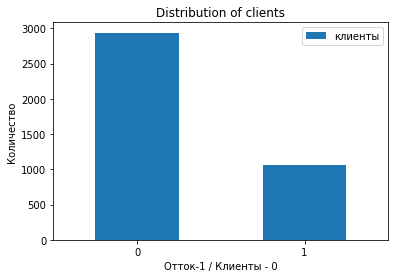

In [10]:
# построим визуализацию предыдущего вывода
gym_churn['churn'].value_counts() \
                  .plot(kind='bar',
                        label='клиенты',
                        xlabel='Отток-1 / Клиенты - 0',
                        ylabel='Количество',
                        title='Distribution of clients',
                        rot=0
                       )
plt.legend()                                       
plt.show()

In [11]:
# функция для построения графика распределения признаков с группировкой по оттоку 
def distribution_plot(feature):
    df_grouped = (
        gym_churn.groupby(['churn', feature])
                 .agg({'avg_class_frequency_total': 'count'})
                 .reset_index()
    )
    ax=sns.barplot(data=df_grouped,
                x=feature,
                y='avg_class_frequency_total',
                hue='churn'
    )
    plt.title=f'Distribution of {feature}'
    ax.set_ylabel('clients')

### Распределение оттока по полу

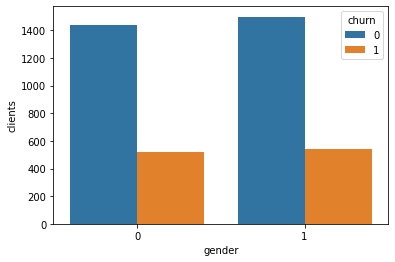

In [12]:
distribution_plot('gender')

### Распределение оттока по близости к работе/дому

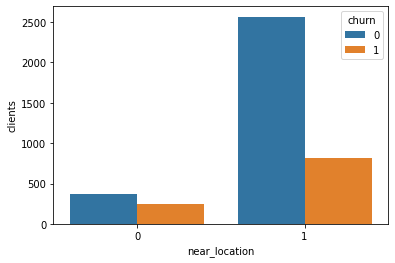

In [13]:
distribution_plot('near_location')

### Распределение по партнерству с ФЦ

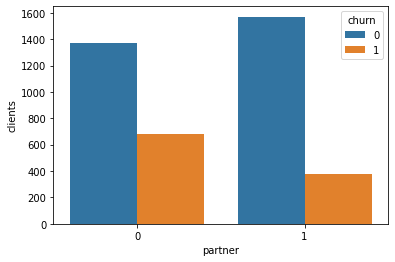

In [14]:
distribution_plot('partner')

### Распределение по наличию телефона

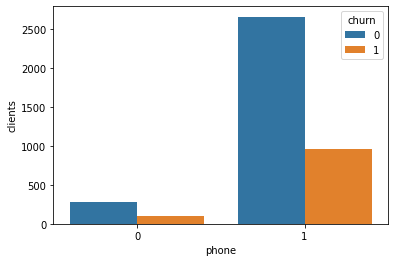

In [15]:
distribution_plot('phone')

### Распределение по промо "Приведи друга"

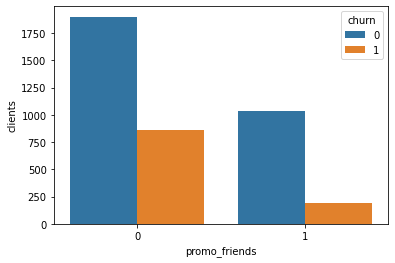

In [16]:
distribution_plot('promo_friends')

### Распределение по длительности абонемента

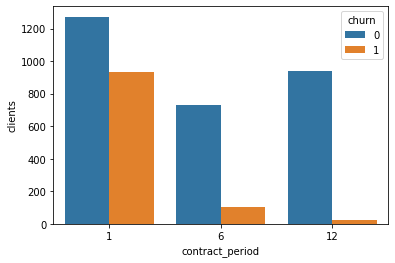

In [17]:
distribution_plot('contract_period')

### Распределение по посещению групповых занятий

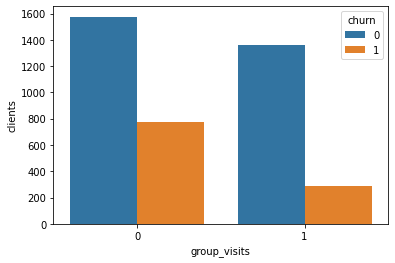

In [18]:
distribution_plot('group_visits')

### Распределение по возрасту

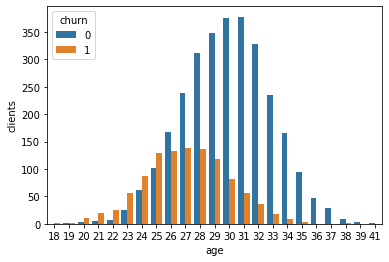

In [19]:
distribution_plot('age')

### Распределение по сроку окончания абонемента

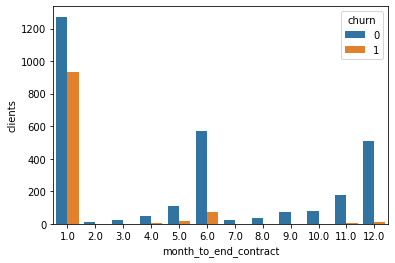

In [20]:
distribution_plot('month_to_end_contract')

### Распределение по времени с момента первого обращения

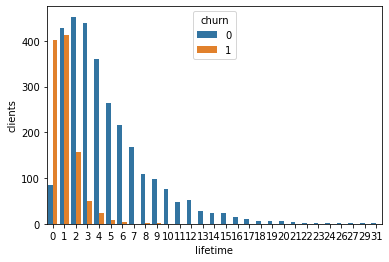

In [21]:
distribution_plot('lifetime')

### Распределение по средней выручке за дополнительные услуги

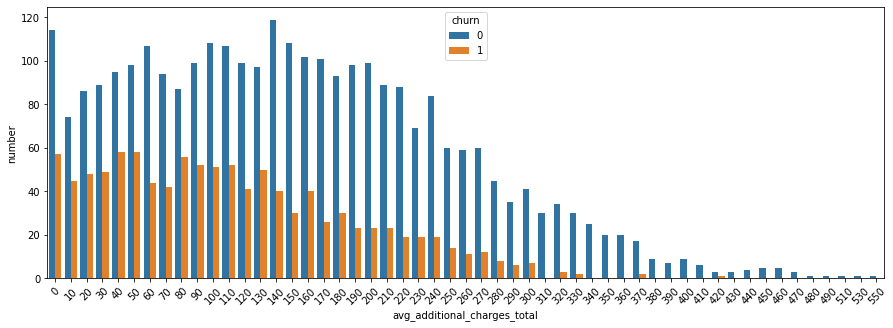

In [22]:
# создадим копию исходного датасета
gym_churn_copy = gym_churn.copy()

# приведем значения поля общих расходов за допуслуги кратно 10-ти
gym_churn_copy['avg_additional_charges_total'] = (
                gym_churn_copy['avg_additional_charges_total'].apply(lambda x: int(x / 10) * 10)
)
df_grouped = (
        gym_churn_copy.groupby(['churn', 'avg_additional_charges_total'])
                      .agg({'avg_class_frequency_total': 'count'})
                      .reset_index()
    )
plt.figure(figsize=(15,5))
ax=sns.barplot(data=df_grouped,
               x='avg_additional_charges_total',
               y='avg_class_frequency_total',
               hue='churn'
    )
ax.tick_params(axis='x', rotation=45)
plt.ylabel('number')
plt.show()

### Распределение средней частоты посещений в неделю за весь период

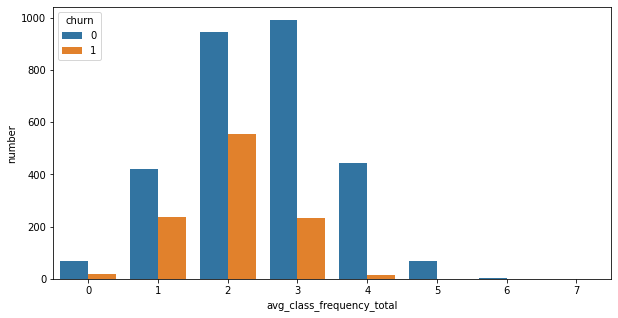

In [23]:
# округлим до целого количество дней посещения в неделю
gym_churn_copy['avg_class_frequency_total'] = (
                    gym_churn_copy['avg_class_frequency_total'].apply(ceil)
)
df_grouped1 = (
        gym_churn_copy.groupby(['churn', 'avg_class_frequency_total'])
                      .agg({'gender': 'count'})
                      .reset_index()
    )
plt.figure(figsize=(10,5))
ax=sns.barplot(data=df_grouped1,
               x='avg_class_frequency_total',
               y='gender',
               hue='churn'
    )
plt.ylabel('number')
plt.show()

### Распределение средней частоты посещений за предыдущий месяц 

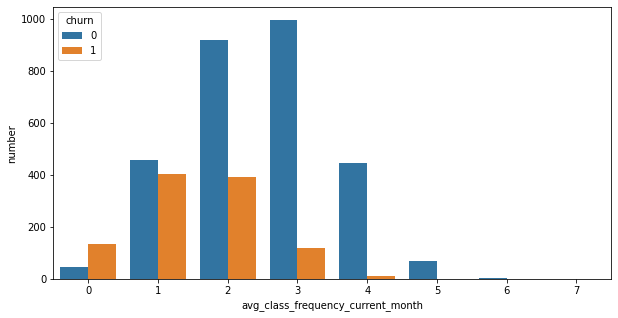

In [24]:
# округлим до целого количество дней посещения в неделю
gym_churn_copy['avg_class_frequency_current_month'] = (
                    gym_churn_copy['avg_class_frequency_current_month'].apply(ceil)
)

df_grouped2 = (
        gym_churn_copy.groupby(['churn', 'avg_class_frequency_current_month'])
                      .agg({'gender': 'count'})
                      .reset_index()
    )
plt.figure(figsize=(10,5))
ax=sns.barplot(data=df_grouped2,
               x='avg_class_frequency_current_month',
               y='gender',
               hue='churn'
    )
plt.ylabel('number')
plt.show()

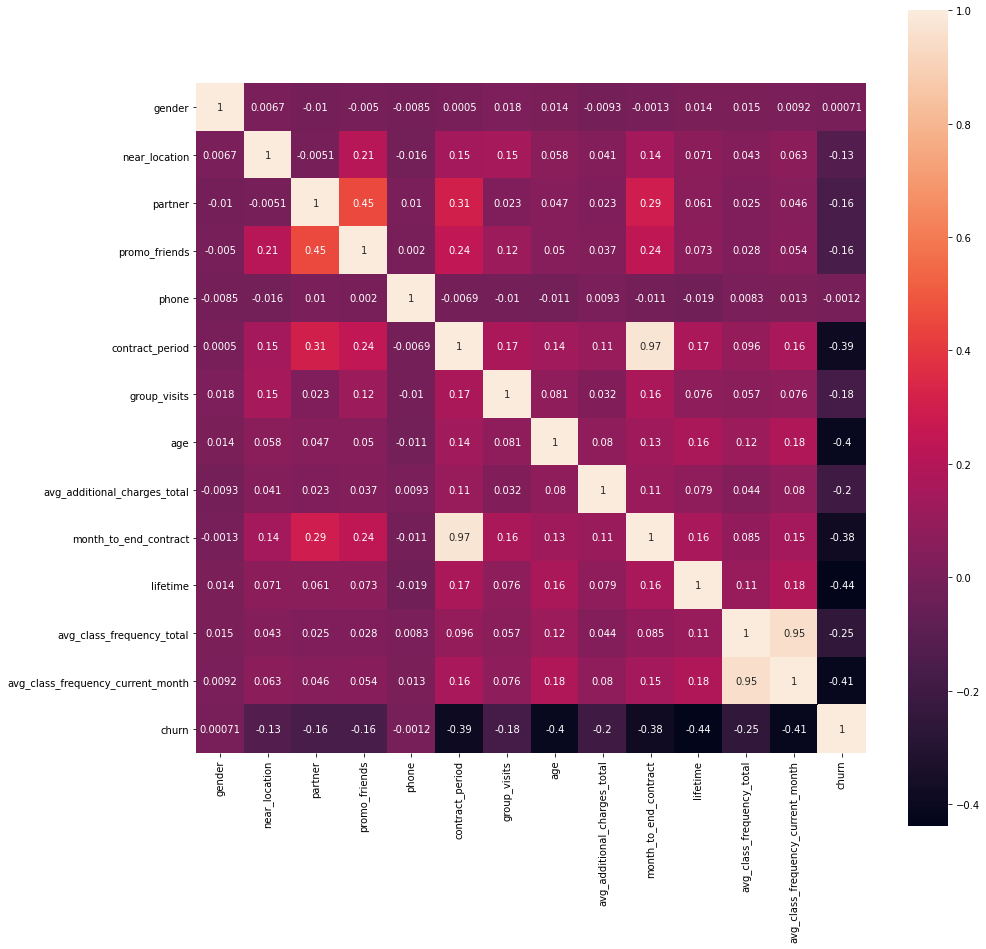

In [25]:
# корреляционная матрица
corr_m = gym_churn.corr()

# нарисуем heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show() 

<b>Вывод:</b> Данный график говорит нам о высокой корреляции между показателями парами `month_to_end_contract - contract_period` и `avg_class_frequency_current_month - avg_class_frequency_total`. Чтобы избежать мультиколлинеарности при обучении моделей исключим из каждой пары по одной характеристике: month_to_end_contract (срок до окончания текущего действующего абонемента (в месяцах)) и avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц) соответственно.

In [26]:
gym_churn_copy.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1, inplace=True)
gym_churn_copy.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total',
       'churn'],
      dtype='object')

##  Построение моделей прогнозирования оттока

In [27]:
# подготовка данных для ML
X = gym_churn_copy.drop('churn', axis=1)
y = gym_churn_copy['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test)

# список моделей
models = [
    LogisticRegression(solver='liblinear' ,random_state=0), # модель логистической регрессии
    RandomForestClassifier(random_state=0)                  # модель классификации "случайный лес"
]

# функция прогноза
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred)))

# оценки каждой модели
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0, solver='liblinear')
	Accuracy: 0.90
	Precision: 0.78
	Recall: 0.81
RandomForestClassifier(random_state=0)
	Accuracy: 0.89
	Precision: 0.78
	Recall: 0.77


<ul>
    <li>По доле правильных ответов (<b>Accuracy</b>) чуть точнее модель логистической регрессии: <b>0.9 против 0.89</b>.
    <li>Обе модели продемонстрировали одинаковую точность (<b>Precision</b>) - долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, <b>0.79</b>.
    <li>Доля объектов положительного класса из всех объектов положительного класса которую нашел алгоритм - полнота (<b>Recall</b>) выше у модели логистической регрессии, <b>0.81 против 0.76</b> у модели классификации с помощью "случайного леса".
</ul>

<p><i>Вывод:</i> <b>LogisticRegression имеет наиболее точный прогноз в сравнении с RandomForestClassifier</b>.

## Кластеризация клиентов

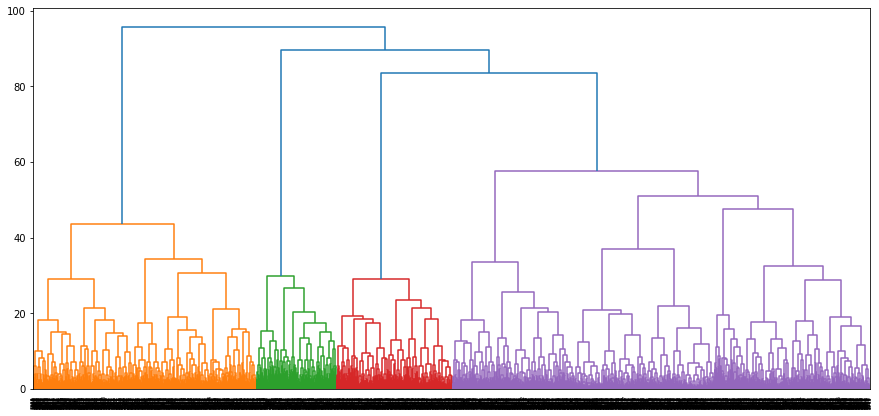

In [28]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 7))
dendrogram(linked, orientation='top')
plt.show()

<b>Предложенное оптимальное число кластеров равно четырем</b>

In [29]:
# согласно условиям проекта (Договоримся за число кластеров принять n=5, 
# чтобы ваши результаты можно было сравнивать с результатами остальных студентов) 

# кластеризация на 5 кластеров
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean().round()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.0,1.0,1.0,1.0,1.0,8.0,0.0,30.0,155.0,7.0,4.0,2.0,2.0,0.0
1,0.0,0.0,0.0,0.0,1.0,3.0,0.0,29.0,138.0,3.0,3.0,2.0,2.0,0.0
2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,29.0,143.0,3.0,3.0,2.0,2.0,0.0
3,1.0,1.0,0.0,0.0,1.0,4.0,1.0,29.0,149.0,3.0,4.0,2.0,2.0,0.0
4,1.0,1.0,0.0,0.0,0.0,5.0,0.0,29.0,144.0,4.0,4.0,2.0,2.0,0.0


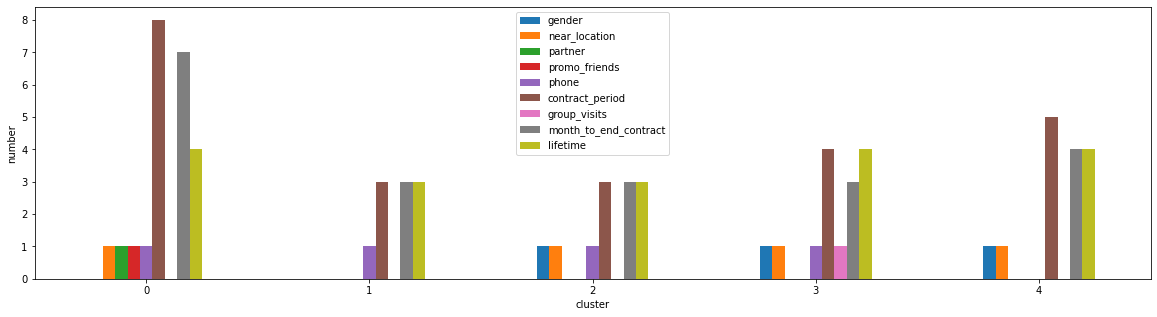

In [30]:
# визуализация усредненных признаков по каждому кластеру
gym_churn.groupby('cluster_km', as_index=False) \
         .mean() \
         .round() \
         .plot(kind='bar', 
               figsize=(20, 5),
               rot=0,
               x='cluster_km',
               xlabel='cluster',
               ylabel='number',
               y=['gender', 'near_location', 'partner', 'promo_friends', 'phone',
                  'contract_period', 'group_visits',
                  'month_to_end_contract', 'lifetime'
                 ]
              );

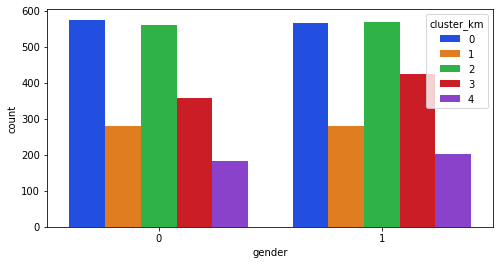

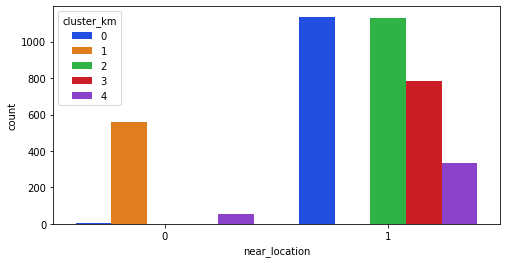

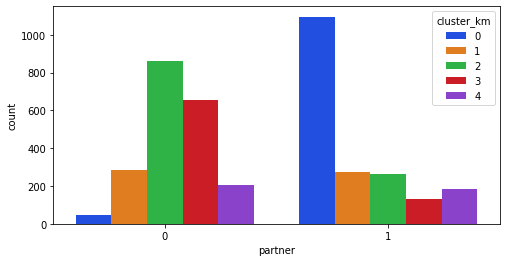

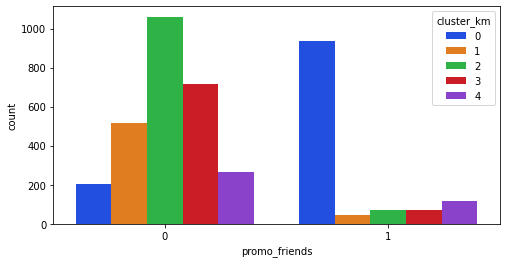

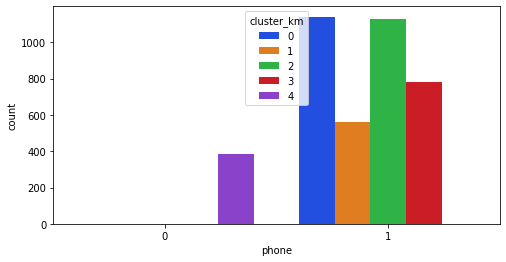

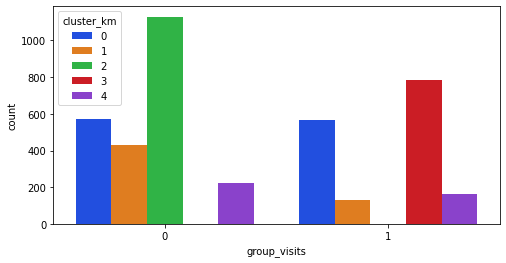

In [98]:
# визуализация категориальных переменных
palette = sns.color_palette(palette='prism', 
                            n_colors=5
                           )
categorical_columns = ['gender', 
                       'near_location', 
                       'partner', 
                       'promo_friends', 
                       'phone',
                       'group_visits'
                      ]

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=column, hue="cluster_km", data=gym_churn)
    plt.show()

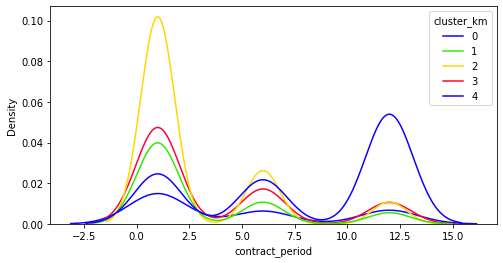

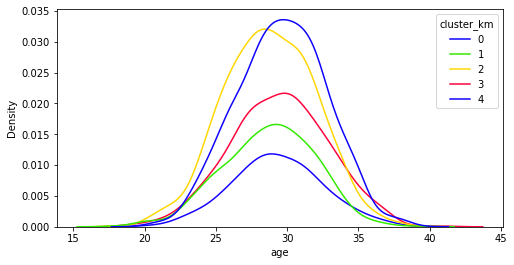

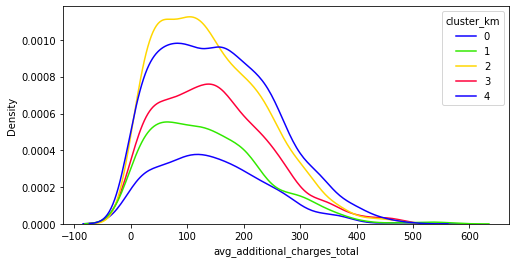

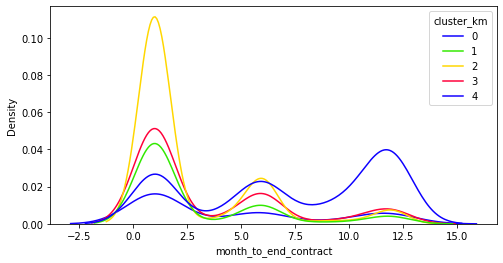

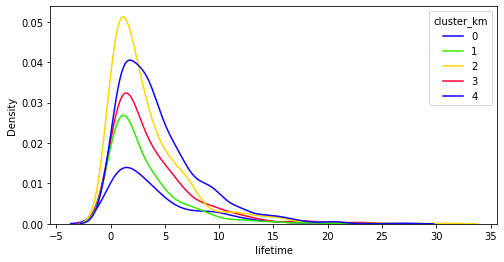

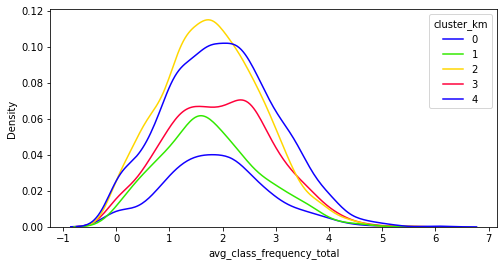

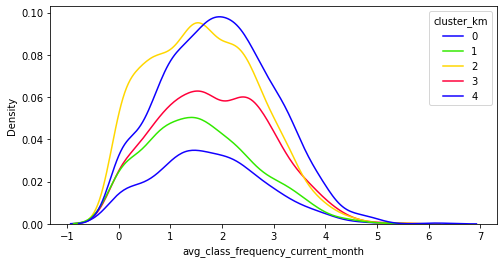

In [99]:
# визуализация количественных переменных
quantitative_columns = [
       'contract_period', 'age', 'avg_additional_charges_total', 
       'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 
       'avg_class_frequency_current_month'
]

for column in quantitative_columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(x=column, 
                 hue="cluster_km", 
                 data=gym_churn, 
                 palette=palette
    )
    plt.show()

<p><b>Отличительные особенности каждого кластера:</b>
<ul>
        <li><b>Кластер_0:</b> мужчины, которые не проживают/работают в районе ФЦ, не являются партнером, текущий средний абонемент 3 мес., не посещающие групповых занятий, тратящие в среднем 138 у.е. на допуслуги ФЦ.</li>
        <p>    
        <li><b>Кластер_1:</b> мужчины, которые проживают/работают в районе ФЦ, сотрудники компании-партнера участвующие в промо (использовал промо-код от знакомого при оплате первого абонемента),  текущий средний абонемент 8 мес., не посещающие групповых занятий, тратящие в среднем 156 у.е. на допуслуги ФЦ.</li>
        <p>
        <li><b>Кластер_2:</b> женщины, которые проживают/работают в районе ФЦ, не являются партнером, текущий средний абонемент 3 мес., не посещающие групповые занятия, тратящие в среднем 143 у.е. на допуслуги ФЦ.</li>
        <p>
        <li><b>Кластер_3:</b> женщины, которые проживают/работают в районе ФЦ, не являются партнером, текущий средний абонемент 5 мес., не посещающие групповые занятия, тратящие в среднем 148 у.е. на допуслуги ФЦ.</li>
        <p>
        <li><b>Кластер_4:</b> женщины, которые проживают/работают в районе ФЦ, не являются партнером, текущий средний абонемент 5 мес., не посещающие групповые занятия, тратящие в среднем 144 у.е. на допуслуги ФЦ.</li>
</ul>

<p><b>Общие черты для всех кластеров:</b>
    <ul>
        <li>Средний возраст посетителей составляет <b>29-30 лет</b>;
        <li>Средняя частота посещений как за последний месяц, так и за все время <b>2 раза неделю</b>;
        <li>Средний период посещения ФЦ от <b>3-ех до 4-ех месяцев</b>.     
    </ul>    

## Выводы и рекомендации

Текущий абонемент
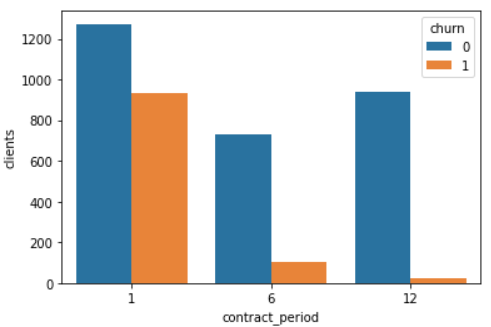
Возраст
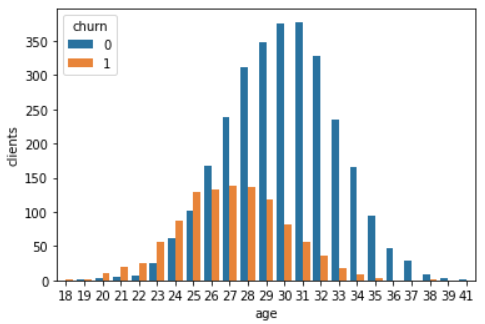
Месяцев до окончания текущего абонемента
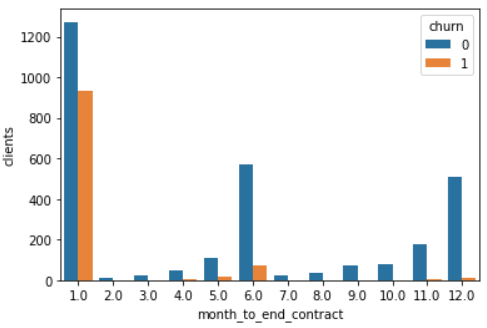
Средняя сумма потраченная на допуслуги ФЦ
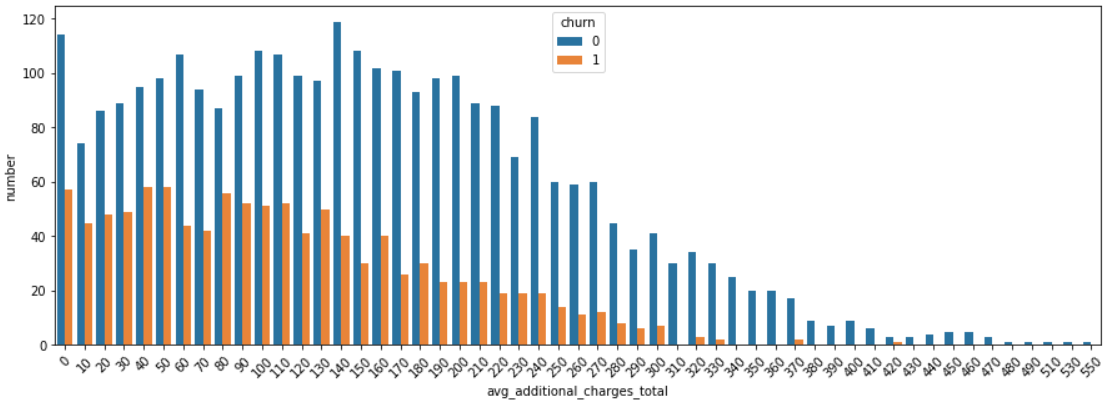
Частота посещаний в неделю
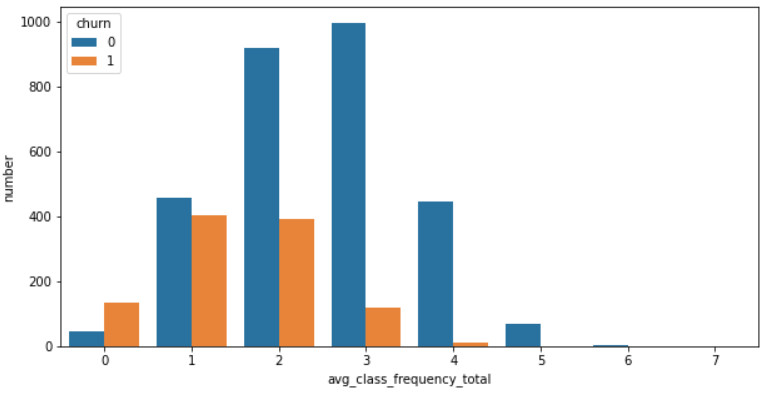

<p><b>Вывод:</b> Наибольший отток наблюдается среди посетителей в возрасте от 25 до 29 лет, которые приобрели месячный абонемент. Такие клиенты склонны к небольшим тратам на дополнительные услуги: кафе, спорттовары, косметический и массажный салон. В среднем такие клиенты посещают ФЦ не более 2-ух раз в неделю.

<p><b>Рекомендации:</b>

<p><u>В рамках пилотного проекта:</u>
    <ol>
        <li>Отобрать наиболее лояльных клиентов из "группы риска" (возраст от 25 до 29 лет, посещающих хотя бы раз в неделю и пользующихся дополнительными услугами ФЦ).
        <li>Предложить льготное продление абонемента еще на 2 месяца с условием посещения не менее 2-ух дней в неделю.
        <li>Предложить скидки на услуги ФЦ.
    </ol>